# Getting started with SCIFYsim

## Import the library

In [1]:
import scifysim as sf
import numpy as np
import matplotlib.pyplot as plt
# optional (when using dark interfaces)
plt.style.use("dark_background")

Building a model from scratch


In [2]:
my_target = "GJ 86 A"

In [3]:
print("SCIFYsim version: ", sf.version)
sf.logit.setLevel(sf.logging.ERROR)
t_exp =1.
seed = 10
expname = "R400_base_sensitivity"
save_results = False

SCIFYsim version:  0.2.2


In [4]:
configfile = "config/default_R400.ini"

In [5]:
asim = sf.utilities.prepare_all(configfile, thetarget=my_target, update_params=True,
                  instrumental_errors=True, seed=seed, update_start_end=False)
asim.combiner.chromatic_matrix(asim.lambda_science_range)

WARNING-astroquery- UnitsWarning: Unit 'e' not supported by the VOUnit standard. 
WARNING-astroquery- UnitsWarning: Unit 'Sun' not supported by the VOUnit standard. Did you mean uN?
ERROR-scifysim.utilities- Couldn't find the entry in JSDC catalog
Dist set to  10.786997784350653 [pc]
T set to  5263.5 [K]
R set to  0.77 [R_sun]
ERROR-scifysim.injection- Now we use fpath to provide the root for appendix config files


0.010342691863670104
sep =  4.5
pa =  60.0
offset =  (-3.8971143170299736, 2.2500000000000004)
inside_tuning [ 0.00000000e+00 -4.13720848e-08  0.00000000e+00 -4.13724906e-08] [ 0.         -0.00014521  0.         -0.00014521]


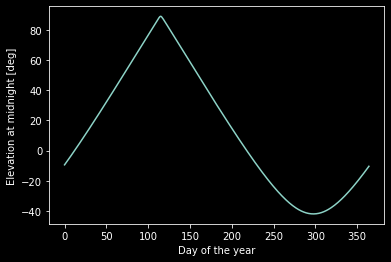

Best time: 2021-04-26T03:00:00.000
WARNING-astroquery- UnitsWarning: Unit 'e' not supported by the VOUnit standard. 
WARNING-astroquery- UnitsWarning: Unit 'Sun' not supported by the VOUnit standard. Did you mean uN?
Sequence start set to  2021-04-26T00:00:00.000
Sequence end set to  2021-04-26T06:00:00.000
ERROR-scifysim.injection- Now we use fpath to provide the root for appendix config files


0.010342691863670104
sep =  4.5
pa =  60.0
offset =  (-3.8971143170299736, 2.2500000000000004)
inside_tuning [ 0.00000000e+00 -4.13720848e-08  0.00000000e+00 -4.13724906e-08] [ 0.         -0.00014521  0.         -0.00014521]


In [6]:
asim.context = sf.analysis.spectral_context(asim.config)#("config/vega_R400.ini")

In [7]:
diffuse = [asim.src.sky, asim.src.UT, asim.src.warm_optics, asim.src.combiner, asim.src.cold_optics]


# Making some exposure

## First, point the instrument to your target

In [8]:
asim.point(asim.sequence[3], asim.target)

## Then you can start an integration

In [9]:
integ = asim.make_metrologic_exposure(asim.src.planet, asim.src.star, diffuse,
                                      texp=t_exp)
integ.prepare_t_exp_base()

integ.consolidate_metrologic()

100%|█████████████████████████████████████████| 200/200 [00:02<00:00, 72.91it/s]


<IPython.core.display.Math object>

## Nice view of the results

In [10]:
shift_step = 1/(asim.n_spec_ch+2)
outputs = np.arange(integ.summed_signal.shape[2])
isources = np.arange(len(integ.sums))
raw_sources = [integ.static[0], integ.static[1],
               integ.static[2], integ.static[3],
               integ.static, integ.starlight, integ.planetlight]

(67, 8)


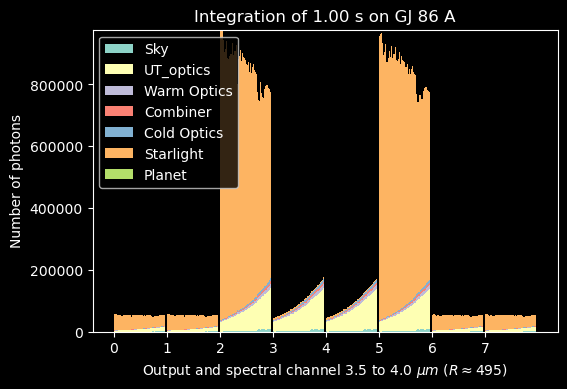

In [11]:
bottom = np.zeros_like(integ.sums[0])
pup = 1 # The pupil for which to plot the piston
print(integ.sums[0].shape)
signalplot = plt.figure(dpi=100)
bars = []
read_noise = integ.ron
for ksource, (thesource, label) in enumerate(zip(integ.sums, integ.source_labels)):
    photon_noise = np.sqrt(thesource)
    if ksource >= len(integ.static):
        inst_noise = np.std(raw_sources[ksource], axis=0)
    else:
        inst_noise = np.zeros((asim.lambda_science_range.shape[0], outputs.shape[0]))
    #print("Inst noise", ksource,  inst_noise.mean(axis=0))
    #print("Photon noise", ksource, photon_noise.mean(axis=0))
    noise = np.sqrt(photon_noise**2 + read_noise**2 + inst_noise**2)
    for ilamb in range(asim.lambda_science_range.shape[0]):
        #print(ksource, ilamb, label)
        #pdb.set_trace()
        if ilamb == 0:
            bars.append(plt.bar(outputs+shift_step*ilamb, thesource[ilamb,:], bottom=bottom[ilamb,:],
                label=label, width=shift_step, color="C%d"%ksource)) #yerr=noise[ilamb,:]
        else:
            bars.append(plt.bar(outputs+shift_step*ilamb, thesource[ilamb,:], bottom=bottom[ilamb,:],
                width=shift_step,  color="C%d"%ksource)) #yerr=noise[ilamb,:]
    bottom += thesource
#plt.legend((bars[i][0] for i in range(len(bars))), source_labels)
#Handled the legend with an condition in the loop
plt.legend(loc="upper left")
plt.xticks(outputs)
plt.xlabel(r"Output and spectral channel %.1f to %.1f $\mu m$ ($R\approx %.0f$)"%(asim.lambda_science_range[0]*1e6,
                                                                                 asim.lambda_science_range[-1]*1e6,
                                                                                 asim.R.mean()))
plt.title("Integration of %.2f s on %s"%(t_exp, asim.tarname))
plt.ylabel("Number of photons")
plt.show()

## Standard exposure


In [12]:
dit = 1.

In [13]:
integ = asim.make_exposure(asim.src.planet, asim.src.star, diffuse,
                                texp=dit,
                                monitor_phase=False,
                               spectro=asim.spectro)

In [14]:
from tqdm import tqdm
n_frames = 100
mynpix = 8
diffuse = [asim.src.sky, asim.src.UT, asim.src.warm_optics, asim.src.combiner, asim.src.cold_optics]
screen_age = 0.
reveta = 1/integ.eta
full_record = True
datacube = []
dit_intensity = []
starlights = []
planetlights = []
for i in tqdm(range(n_frames)):
    if screen_age>=20. :
        print("generating screen")
        asim.injector.update_screens()
        screen_age = 0.
    integ = asim.make_exposure(asim.src.planet, asim.src.star, diffuse,
                                texp=dit,
                                monitor_phase=False,
                               spectro=None)
    datacube.append(integ.get_total(spectrograph=None,
                                    t_exp=dit,
                                    n_pixsplit=mynpix))
    dit_intensity.append(reveta * integ.forensics["Expectancy"].sum(axis=0))
    if full_record:
        starlights.append(integ.starlight.astype(np.float32))
        planetlights.append(integ.planetlight.astype(np.float32))
    integ.reset() # This can be removed after new kernel start
    screen_age += dit
datacube = np.array(datacube)
dit_intensity = np.array(dit_intensity)
starlights = np.array(starlights)
planetlights = np.array(planetlights)

 20%|████████▍                                 | 20/100 [00:42<02:46,  2.09s/it]

generating screen


 40%|████████████████▊                         | 40/100 [01:23<02:02,  2.04s/it]

generating screen


 60%|█████████████████████████▏                | 60/100 [02:05<01:22,  2.07s/it]

generating screen


 80%|█████████████████████████████████▌        | 80/100 [02:47<00:40,  2.03s/it]

generating screen


100%|█████████████████████████████████████████| 100/100 [03:28<00:00,  2.08s/it]


## The combiner matrix

In [15]:

plt.style.use("default")

(6, 12.5)


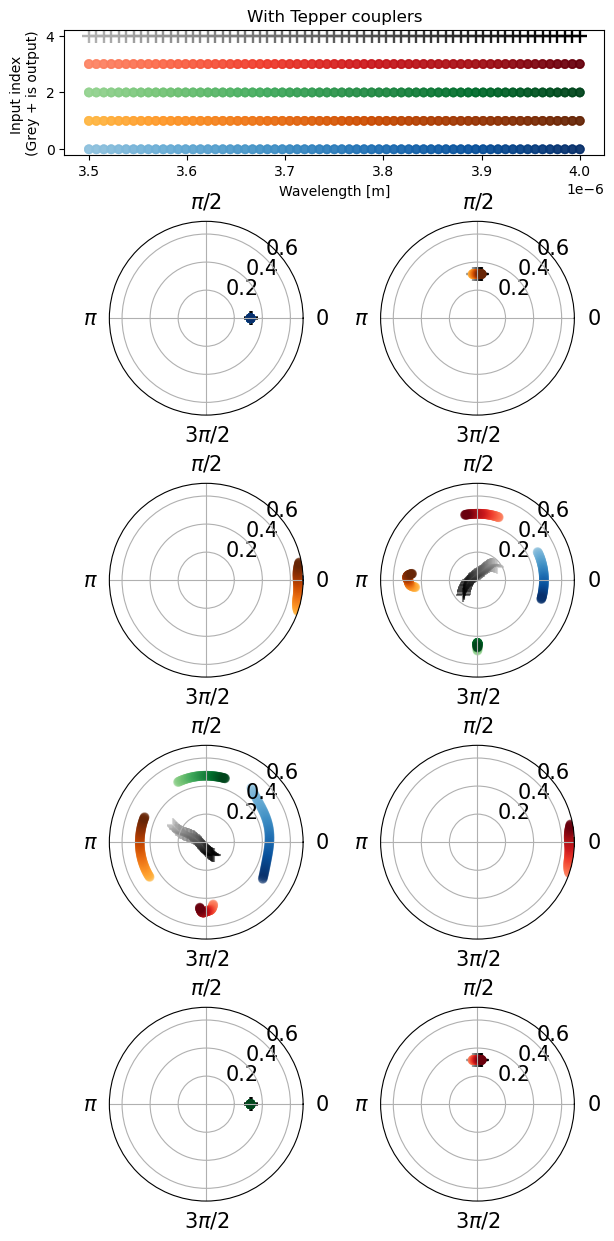

In [16]:
from kernuller.diagrams import plot_chromatic_matrix
fig, axs, matrix = plot_chromatic_matrix(asim.combiner.M,
                                         sf.combiners.lamb, asim.lambda_science_range,
                                         verbose=False, returnmatrix=True,minfrac=0.9,
                                         plotout=True, show=False, title="With Tepper couplers")

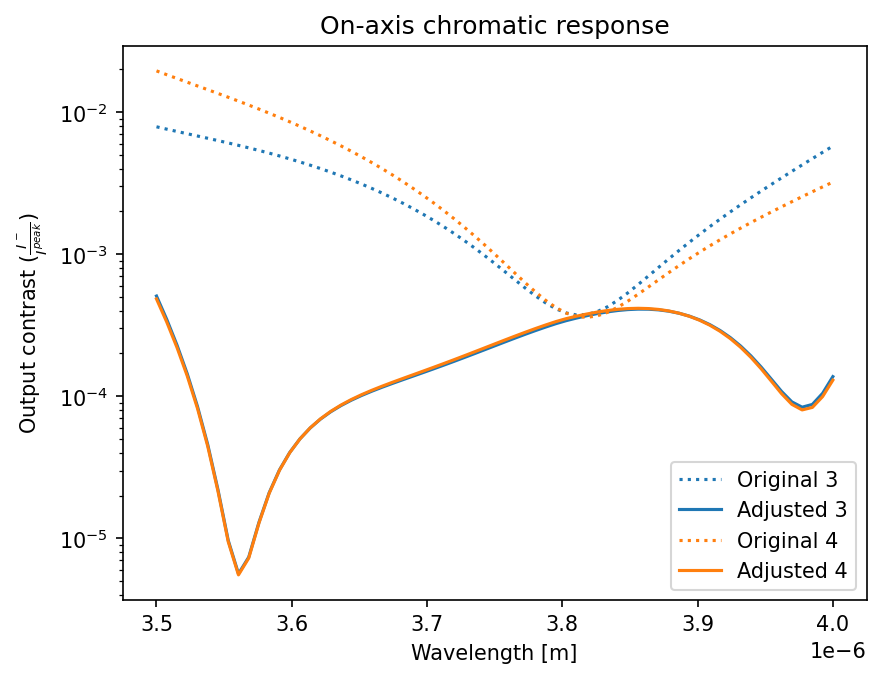

(6, 6.5)
out_switch (67, 4, 4)
inarray (67, 4)



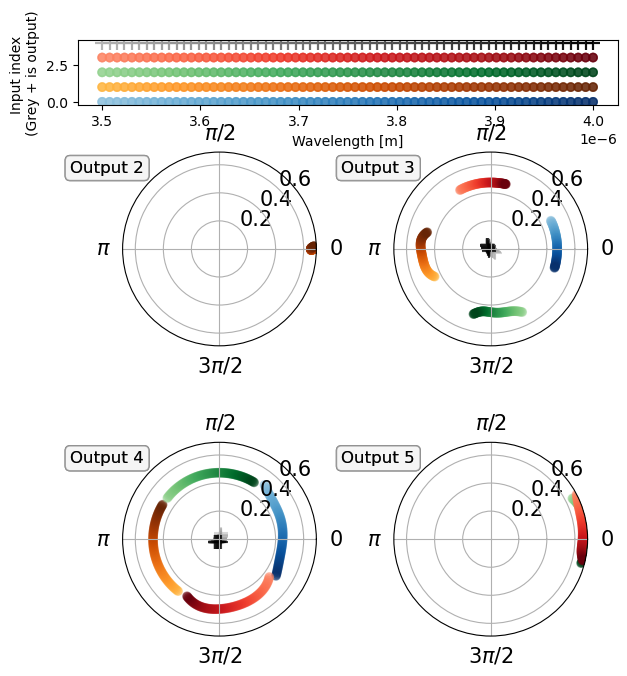

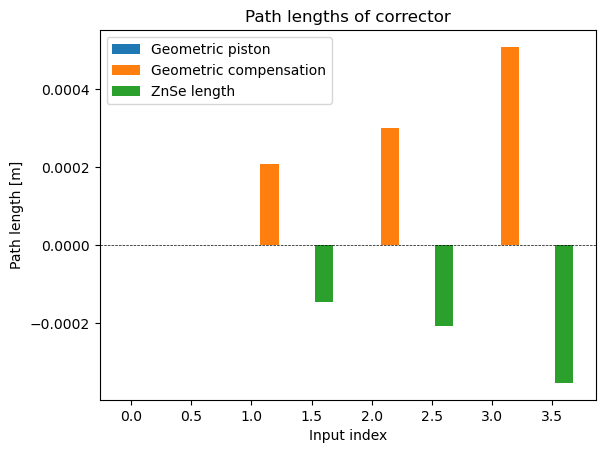

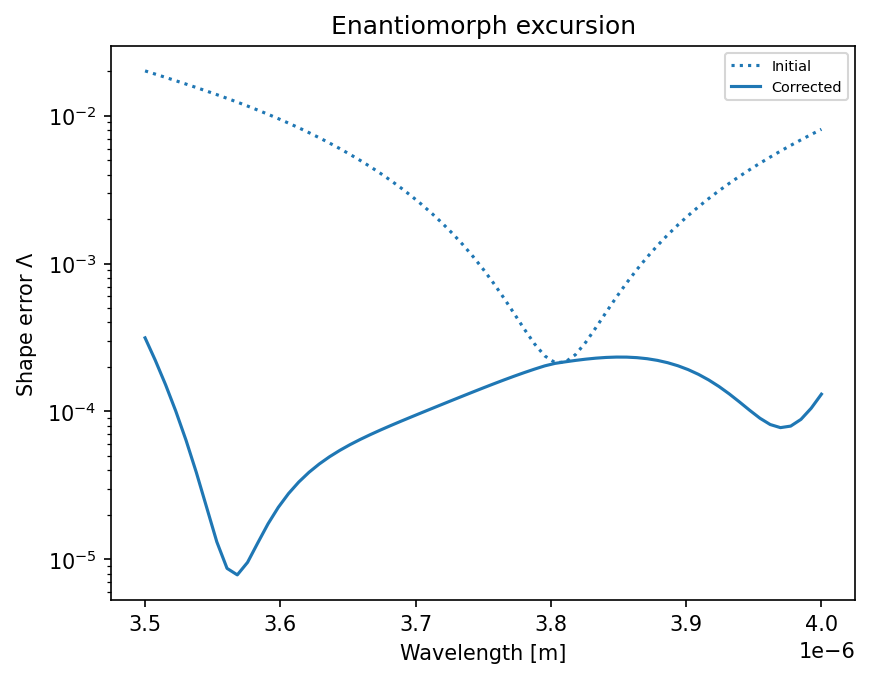

In [17]:
nul_plot, cmp_plot, bar_plot, shape_plot =\
        sf.plot_tools.plot_corrector_tuning_angel_woolf(asim.corrector, asim.lambda_science_range, asim.combiner)

In [18]:
asim.point(asim.sequence[3], asim.target)

In [19]:
from kernuller import pairwise_kernel
ak = pairwise_kernel(2)
myk = np.hstack((np.zeros((1,3)), ak, np.zeros((1,3))))
asim.combiner.K = myk


diffobs = np.einsum("ij, mkj->mk",asim.combiner.K, dit_intensity)
diff_std = np.std(diffobs, axis=0)

In [20]:
integ.reset()
integ = asim.make_exposure(asim.src.planet, asim.src.star, diffuse,
                                texp=dit,
                                monitor_phase=False,
                               spectro=None)
block = integ.get_total(spectrograph=None,t_exp=dit, n_pixsplit=mynpix)
print(f"datacube shape: {datacube.shape}")
print(f"dit = {dit} s")
brigh_max = np.max(np.mean(integ.forensics["Expectancy"][:,:,asim.combiner.bright], axis=0))
dark_max = np.max(np.mean(integ.forensics["Expectancy"][:,:,asim.combiner.dark], axis=0))
longest_exp_bright = 65000 / (brigh_max/dit)
longest_exp_dark = 65000 / (dark_max/dit)
print(f"Bright limit: {longest_exp_bright:.2f} s\n Dark limit: {longest_exp_dark:.2f} s")
data_std = np.std(datacube, axis=0)
diff_std = np.std(datacube[:,:,3]-datacube[:,:,4], axis=0)

integ.static = asim.computed_static
integ.mean_starlight = np.mean(starlights, axis=0)
integ.mean_planetlight = np.mean(planetlights, axis=0)
integ.mean_intensity = np.mean(dit_intensity, axis=0)

datacube shape: (100, 67, 8)
dit = 1.0 s
Bright limit: 0.77 s
 Dark limit: 4.23 s


In [21]:
mkdir /tmp/plots

mkdir: cannot create directory ‘/tmp/plots’: File exists


/lhome/romain/Documents/hi5/SCIFYsim/scifysim/analysis.py:255: RuntimeWarning: divide by zero encountered in log10
  amag = -2.5*np.log10(flux/self.thevegassflux)


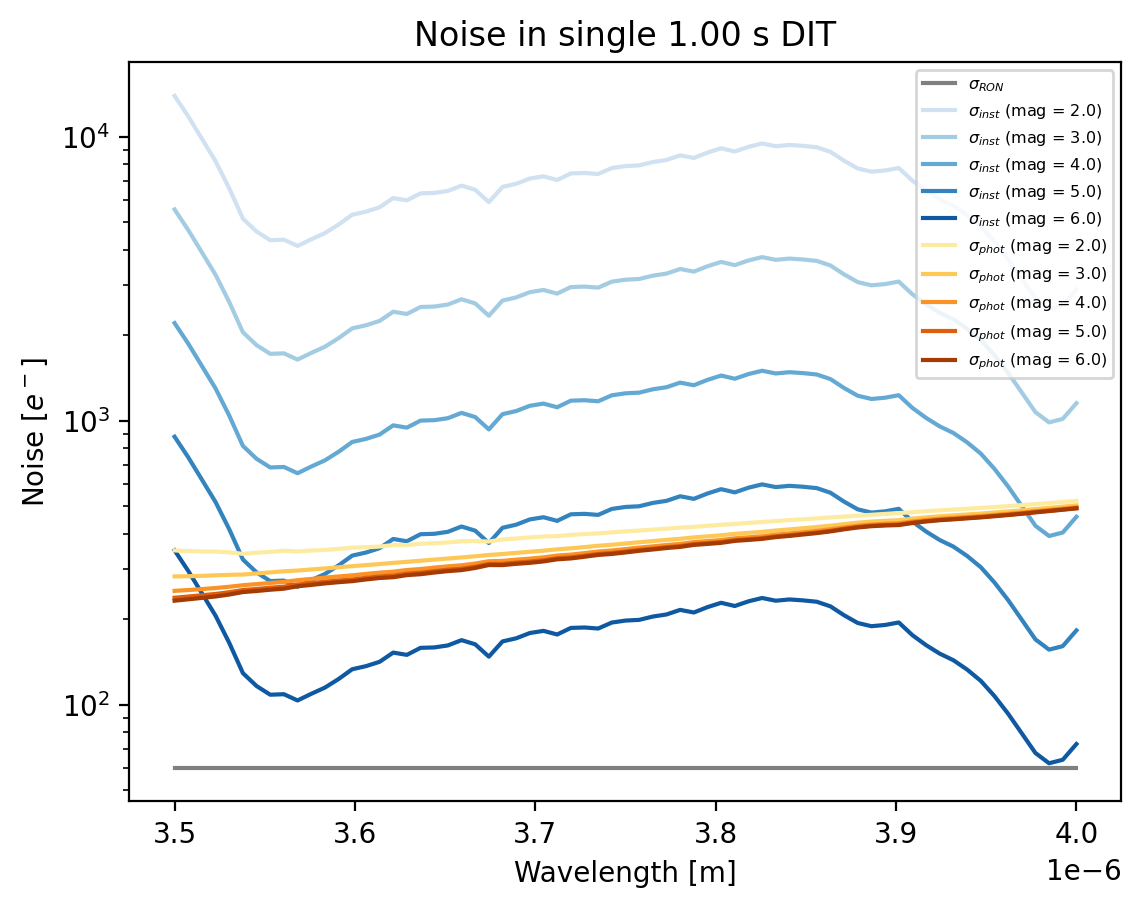

In [22]:
prof = sf.analysis.noiseprofile(integ, asim, diffobs, n_pixsplit=mynpix)
fig = prof.plot_noise_sources(asim.lambda_science_range, dit=1., show=False,
                             ymin=0.2, ymax=1.)
plt.legend(loc="upper right", fontsize="xx-small")

plt.savefig("/tmp/plots/noises.pdf", bbox_inches='tight', dpi=200)
plt.show()

# Building a correlation map

## Dealing with the noise:

This is to take into account the noise in your observation data. You should adjust it depending on your observation case

In [23]:
from scipy.linalg import sqrtm
ndits = 100 # the number of dits taken within each chunk. (at R=400 dit~2s)
adit = 2.   # The value of dit
starmag = 4. # Magnitude of the star
             # Can also be obtained from `asim.context.get_mags_of_sim(asim)` which gives both
             # star and planet mag based on `asim.src`
amat = 1/ndits * prof.diff_noise_floor_dit(starmag, adit, matrix=True)
wmat = sqrtm(np.linalg.inv(amat))
whitenings = np.ones(len(asim.sequence))[:,None,None]*wmat[None,:,:]

## Creating some signal

Do not use this cell if you are creating your data separately.

This is a simplistic model with synthetic noise and straight signal propagation.

To be more thorough, one would use direct MC simulations.

In [24]:
noise = np.random.multivariate_normal(mean=np.zeros(amat.shape[0]), cov=amat, size=(len(asim.sequence),1))

from lmfit import Parameters
from einops import rearrange

master_params = Parameters()
master_params.add("Sep", value = 5.) # in [mas]
master_params.add("PA", value=45.) # in [deg] East of North
master_params.add("Temperature", value=1012) # in K
master_params.add("Radius", value=0.09) # in R_sun


master_source = sf.analysis.make_source(master_params, asim.lambda_science_range, asim.src.distance)
master_light = sf.analysis.make_th_exps(asim, adit, master_source, diffuse, obs=asim.obs)
master_diff = np.einsum("k o, n w o -> n w k", asim.combiner.K, master_light)

noised_observation = master_diff + rearrange(noise, "nblock nk nwl -> nblock nwl nk")

## Creating the correlation map

In [25]:
asim.build_all_maps_dask(mapres=100, mapcrop=0.3)
bymap = sf.utilities.extract_diffobs_map(asim.maps, asim, dit=adit,
                            postprod=None, eta=asim.integrator.eta)
#full_wmat = np.ones(bymap.shape[0])[:,None,None]*wmat[None,:,:]
cmap, xtx_map = sf.analysis.correlation_map(noised_observation, bymap.compute(),
                            postproc=whitenings,
                            K=asim.combiner.K[None,:], n_diffobs=1)
norm_map = cmap/np.sqrt(xtx_map)

0.010342691863670104
(20, 67, 8, 10000)
n_diffobs 1
shape2 1


## Locating the Maximum and plotting the result

Note that there is still a problem for the display of direction, as here, RA is increasing from left to right and not from right to left.

In [26]:
cont = np.quantile(norm_map, 0.9995)
loc_norm_map = sf.utilities.get_location(norm_map, asim.map_extent, mode="cartesian")

cartesian: [2.925 2.925]
r, theta 4.136574669941309 -0.7853981633974483


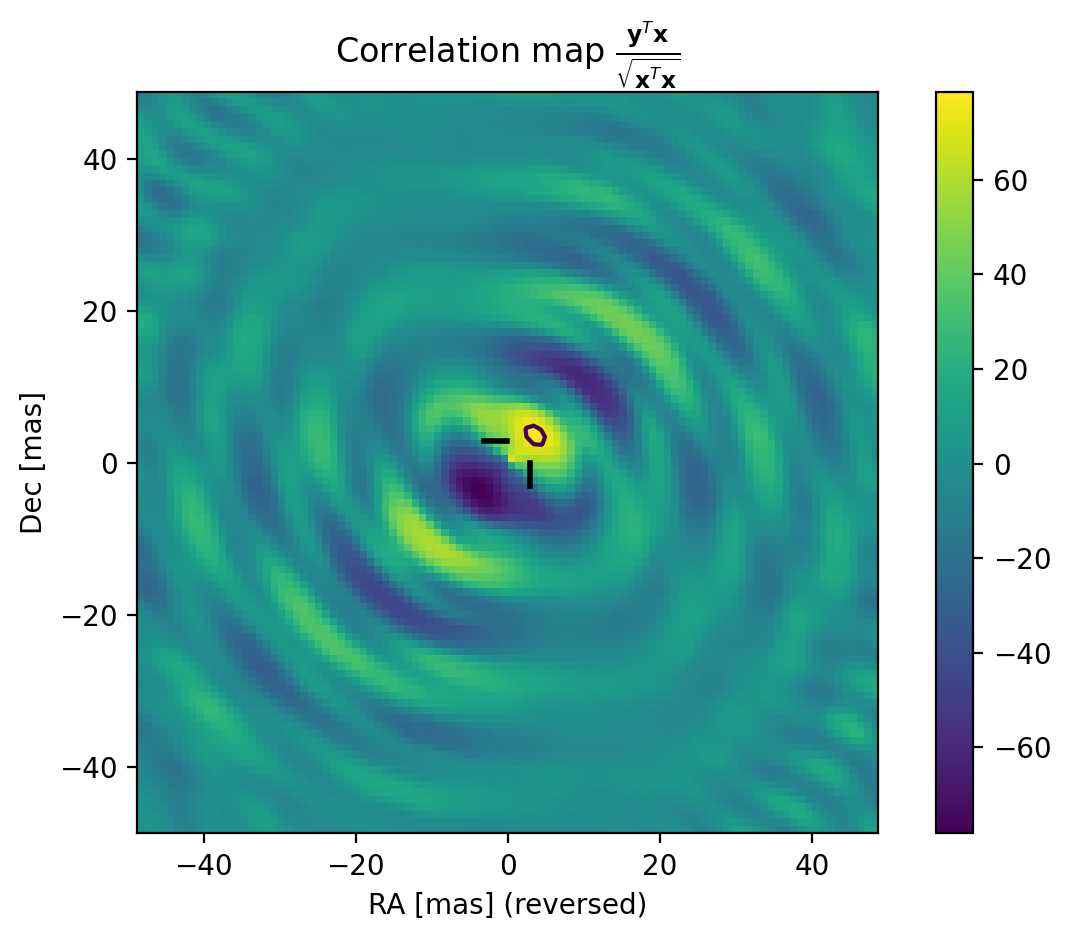

In [29]:
plt.figure(dpi=200)
#plt.subplot(121)
#plt.imshow(cmap, extent=asim.map_extent)
#make_cursor(loc_cmap, 3, linewidth=2.)
#plt.colorbar()
#plt.title(f"Raw map $\\mathbf{{y}}^T\mathbf{{x}}$")
#plt.subplot(122)
plt.imshow(norm_map, extent=asim.map_extent, origin="lower")
plt.colorbar()
plt.contour(norm_map, levels=[cont,], extent=asim.map_extent, origin="lower")
sf.plot_tools.make_cursor(loc_norm_map, 3, linewidth=2., flipy=False)
plt.title(f"Correlation map $\\frac{{\mathbf{{y}}^T\mathbf{{x}}}}{{\\sqrt{{\mathbf{{x}}^T\mathbf{{x}}}}}}$")
plt.xlabel("RA [mas] (reversed)")
plt.ylabel("Dec [mas]")
plt.tight_layout()
plt.show()